# Матрица ошибок


#### Для составления матрицы ошибок используем класс:

     sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
 
     где параматр normalize принимает значения {‘true’, ‘pred’, ‘all’}- нормализация соответственно по строкам(True классы), по столбцам (Predicted классы) или нормализация на общее число объектов выборки, по которой строится матрица.
     по умолчанию значение normalize=None (в каждой ячейке матрицы будет  число объектов выборки)
     
#### Для простой визуализации матрицы ошибок воспользуемся классом:
    sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, *, display_labels=None)

#### Загрузим датасет с несколькими классами

In [85]:
from sklearn.datasets import load_wine
X, y = load_wine(return_X_y=True)
X.shape

(178, 13)

#### Настроим классификатор

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter("ignore")

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,
                                                    random_state=0)
clf = LogisticRegression(multi_class='ovr',max_iter=10)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=10, multi_class='ovr')

#### Отобразим матрицу ошибок на обучающей выборке с абсолютным количеством наблюдений 

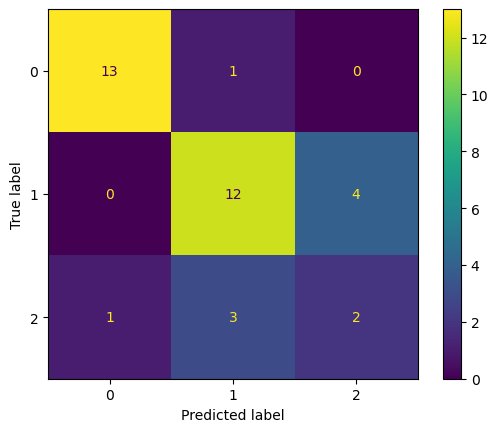

In [87]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

#### Отобразим матрицу ошибок на обучающей выборке с долей от наблюдений всего класса в каждой ячейке матрицы

<Figure size 500x500 with 0 Axes>

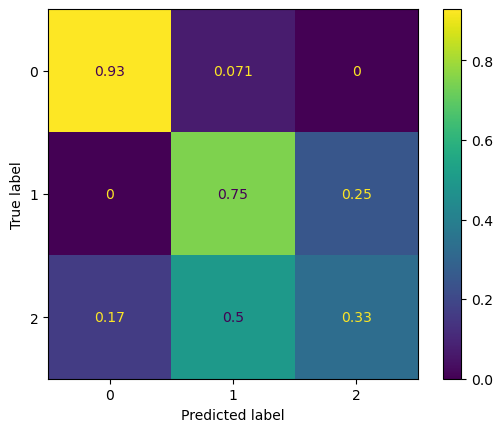

In [88]:
plt.figure(figsize=[5, 5])

predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

# Метрики оценки качества для 2-х классовых задач

#### Возьмём 2-х классовый датасет с данными телеком-оператора об оттоке клиентов. 

Нам важно обучить модель хорошо предсказывать класс '1' (отток клиента), чтобы эффективно распределить маркетинговые ресурсы на клиентов с высокой вероятностью ухода от оператора. При этом наблюдений класса 1 в семпле в 6 раз меньше, чем класса 0. И, используя dummy-модель, мы сразу получим неплохую точность

Что делать, если среди всех клиентов, более сколонных уйти от оператора (большая вероятность оттока), мы хотим лучше предсказывать клиентов с большим ожидаемым LTV?

Тогда нам нужно:
1. настроить регрессионную модель, предсказывающую LTV
2. клиентам с большим ожидаемым LTV присвоить больший вес
3. обучать те же модели классификации, добавив параметр sample_weight в методе fit()

In [89]:
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

df = pd.read_csv('telecom_churn.csv')

d = {'Yes' : 1, 'No' : 0}

df['International plan'] = df['International plan'].map(d)
df['Voice mail plan'] = df['Voice mail plan'].map(d)
df['Churn'] = df['Churn'].astype('int64')

df=df.drop('State',axis=1)
df.head()
y=df['Churn']
X=df.drop('Churn',axis=1)
#X.head()
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,
                                                    random_state=0)

#### Обучим модель логистической регрессии:

In [90]:
from sklearn.linear_model import LogisticRegressionCV

model=LogisticRegressionCV(penalty='l2',Cs=[0.0001,0.001,0.01,0.1,1,10,100],cv=5,
                                       random_state=0)
model.fit(X_train,y_train)

LogisticRegressionCV(Cs=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100], cv=5,
                     random_state=0)

#### Посчитаем accuracy_score:

In [91]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8710644677661169


#### Судя по accuracy_score, полученная модель кажется довольно неплохой

#### Построим матрицу ошибок:

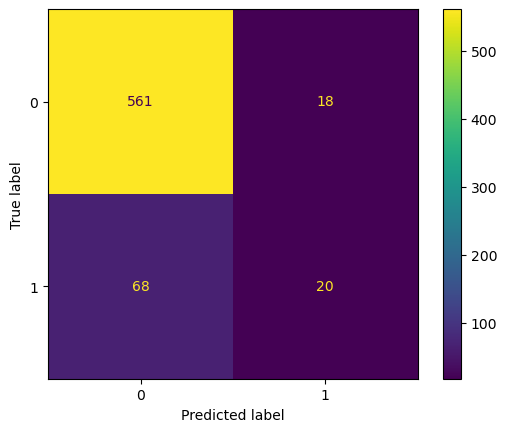

In [96]:

cm = confusion_matrix(y_test, y_pred,labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

#### По матрице ошибок мы видим, насколько несбалансированы классы. Несмотря на то, что accuracy_score неплохой, в классе '1' предсказана верно только меньшая часть объектов. 

### Намного полезнее в такой ситуации ориентироваться на метрики:
    1) точности (precision) 
    2) полноты (recall)
    3) F-меры
    4) взвешенной F-меры

<img src="images/precision_recall.png" width="500" height="300" />

<img src="images/precision_recall_2.png" width="300" height="300"/>

Для вычисления этих метрик воспользуемся классами:
        
    sklearn.metrics.precision_score(y_true, y_pred,...)
    sklearn.metrics.recall_score(y_true, y_pred,...)
    sklearn.metrics.f1_score(y_true, y_pred,...)
    sklearn.metrics.fbeta_score(y_true, y_pred, *, beta,...)  

In [97]:
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score, fbeta_score
def print_metrics(y_test, y_pred):
    print(f'precision_score={precision_score(y_test, y_pred):.3f}')
    print(f'recall_score={recall_score(y_test, y_pred):.3f}')
    print(f'f1_score={f1_score(y_test, y_pred):.3f}')
    print(f'f_score (beta=2)={fbeta_score(y_test, y_pred, beta=2):.3f}')
    print(f'f_score (beta=4)={fbeta_score(y_test, y_pred, beta=4):.3f}')
    
print_metrics(y_test, y_pred)


precision_score=0.526
recall_score=0.227
f1_score=0.317
f_score (beta=2)=0.256
f_score (beta=4)=0.235


## ROC-кривая

будем варьировать решающее правило, по которому относить объект к положительному классу. Более точно,будем регулировать $\alpha$, где

$$\hat y(x) = sign(\beta^T x - \alpha)$$
$$TPR = TPR(\alpha)$$
$$FPR = FPR(\alpha)$$
Площадь под кривой вычислим по формуле:
$$AUC = \int_{-\infty}^{\infty} {TPR} \,d{FPR}$$


### Построим для нашей модели ROC-кривую с помощью класса:

        sklearn.metrics.plot_roc_curve(estimator, X, y, *,...)

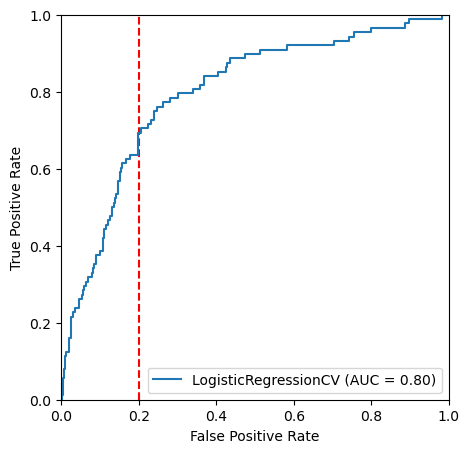

In [101]:
from sklearn.metrics import plot_roc_curve

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot( 1, 1, 1 )
plt.plot([0.2, 0.2], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plot_roc_curve(model,X_test,y_test,ax=ax);


### Сравним ROC - кривые различных моделей
(некоторые модели предварительно настроены на оптимальные параметры)

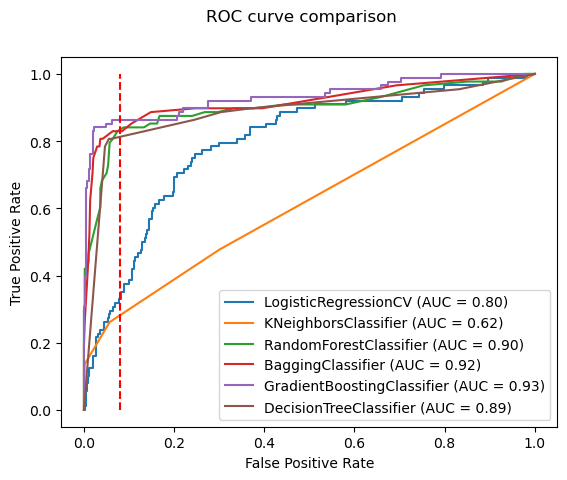

In [104]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier
base_model=DecisionTreeClassifier()
svc = SVC(probability=True)
svc.fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
tree=DecisionTreeClassifier(max_depth=10)
tree.fit(X_train,y_train)
logreg=LogisticRegressionCV(penalty='l2',Cs=[0.0001,0.001,0.01,0.1,1,10,100],cv=5,
                                       random_state=0)
logreg.fit(X_train, y_train)
forest = RandomForestClassifier(n_estimators=89,max_samples=271,max_features=3,random_state=0)
forest.fit(X_train, y_train)
bagging = BaggingClassifier(base_estimator=base_model,max_samples=953,max_features=14,
                        n_estimators=21, random_state=0)
bagging.fit(X_train, y_train)
boost = GradientBoostingClassifier(n_estimators=156, learning_rate=0.1,
    max_depth=5, random_state=0)
boost.fit(X_train, y_train)
#отрисуем на одном графике
log_disp = plot_roc_curve(logreg, X_test, y_test)
#svc_disp = plot_roc_curve(svc, X_test, y_test, ax=log_disp.ax_)
knn_disp = plot_roc_curve(knn, X_test, y_test, ax=log_disp.ax_)
forest_disp = plot_roc_curve(forest, X_test, y_test, ax=log_disp.ax_)
bagging_disp = plot_roc_curve(bagging, X_test, y_test, ax=log_disp.ax_)
boosting_disp = plot_roc_curve(boost, X_test, y_test, ax=log_disp.ax_)
tree_disp = plot_roc_curve(tree, X_test, y_test, ax=log_disp.ax_)
knn_disp.figure_.suptitle("ROC curve comparison")
plt.plot([0.08, 0.08], [0, 1],'r--')

plt.show()


#### Отобразим для каждой модели зависимость fpr, tpr от вероятности оттока, предсказанной моделью

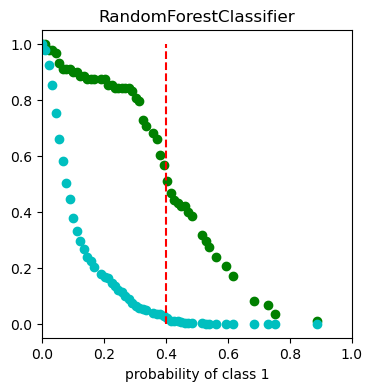

precision_score=0.968
recall_score=0.341
f1_score=0.504
f_score (beta=2)=0.392
f_score (beta=4)=0.354


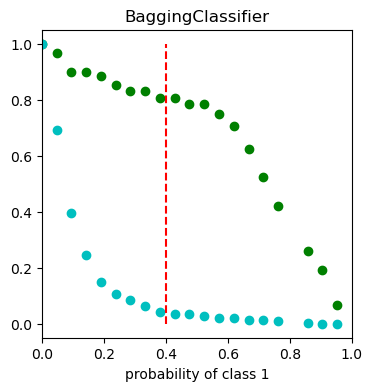

precision_score=0.802
recall_score=0.784
f1_score=0.793
f_score (beta=2)=0.788
f_score (beta=4)=0.785


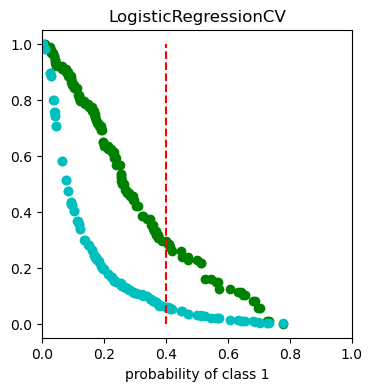

precision_score=0.526
recall_score=0.227
f1_score=0.317
f_score (beta=2)=0.256
f_score (beta=4)=0.235


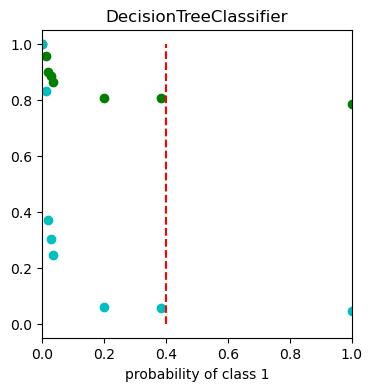

precision_score=0.719
recall_score=0.784
f1_score=0.750
f_score (beta=2)=0.770
f_score (beta=4)=0.780


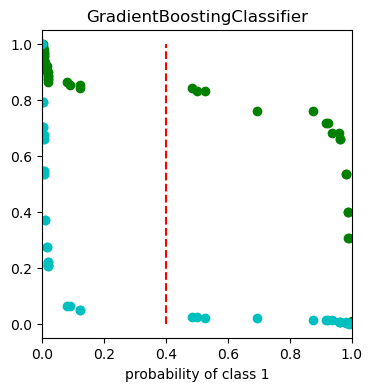

precision_score=0.849
recall_score=0.830
f1_score=0.839
f_score (beta=2)=0.833
f_score (beta=4)=0.831


In [107]:
from sklearn.metrics import roc_auc_score,roc_curve

def roc_curve_trashhold(model,X_test,y_test):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    fig=plt.figure(figsize=[4, 4])
    d=pd.DataFrame(zip(fpr, tpr, thresholds),columns=['fpr','tpr', 'probability'])
    d.sort_values(by=['probability'],ascending=False)
    d.head(70)
    plt.scatter(d['probability'],d['tpr'],c='g')
    plt.scatter(d['probability'],d['fpr'],c='c')
    plt.plot([0.40, 0.40], [0, 1],'r--')
    model_name = type(model).__name__
    plt.xlabel('probability of class 1')
    plt.xlim((0, 1))
    plt.title(model_name)
    plt.show()
    print_metrics(y_test, model.predict(X_test))

roc_curve_trashhold(model=forest,X_test=X_test,y_test=y_test)
roc_curve_trashhold(model=bagging,X_test=X_test,y_test=y_test)
#roc_curve_trashhold(model=svc,X_test=X_test,y_test=y_test)
roc_curve_trashhold(model=logreg,X_test=X_test,y_test=y_test)
roc_curve_trashhold(model=tree,X_test=X_test,y_test=y_test)
roc_curve_trashhold(model=boost,X_test=X_test,y_test=y_test)

Посмотрим, насколько хорошо решающее дерево различает классы

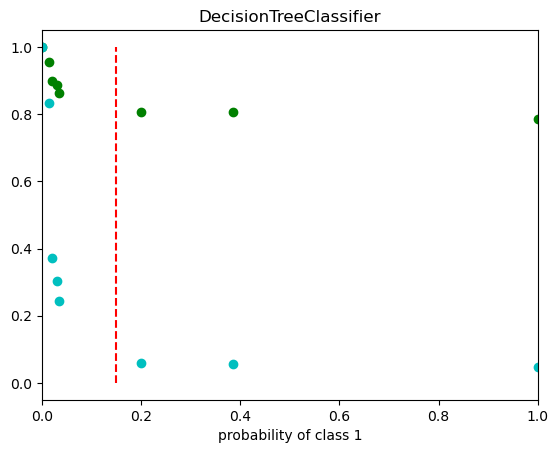

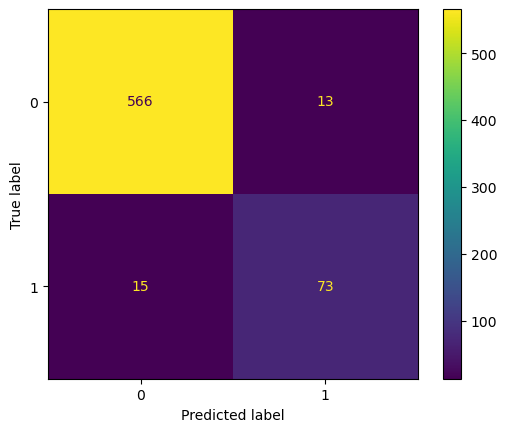

,fpr,tpr,probability
0,0.000000,0.000000,2.000000
1,0.046632,0.784091,1.000000
2,0.055268,0.806818,0.384615
3,0.060449,0.806818,0.200000
4,0.245250,0.863636,0.034979
5,0.303972,0.886364,0.030488
6,0.371330,0.897727,0.019737
7,0.832470,0.954545,0.014519
8,1.000000,1.000000,0.000000


<Figure size 400x400 with 0 Axes>

In [108]:
def roc_curve_trashhold(model,X_test,y_test):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

    d=pd.DataFrame(zip(fpr, tpr, thresholds),columns=['fpr','tpr', 'probability'])
    d.sort_values(by=['probability'],ascending=False)
 
    plt.scatter(d['probability'],d['tpr'],c='g')
    plt.scatter(d['probability'],d['fpr'],c='c')
    plt.plot([0.15, 0.15], [0, 1],'r--')
    model_name = type(model).__name__
    plt.xlabel('probability of class 1')
    plt.xlim((0, 1))
    plt.title(model_name)
    return d.head(70)
    print_metrics(y_test, model.predict(X_test))
df=roc_curve_trashhold(model=tree,X_test=X_test,y_test=y_test)
cm = confusion_matrix(y_test, boost.predict(X_test),labels=tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=tree.classes_)
disp.plot()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:, 1])
fig=plt.figure(figsize=[4, 4])
d=pd.DataFrame(zip(fpr, tpr, thresholds),columns=['fpr','tpr', 'probability'])
d.sort_values(by=['probability'],ascending=False)
d.head(70)

Как видим, одиночное дерево удачной глубины в нашем случае работает достаточно хорошо. Это значит, что мы можем посмотреть на решающие правила, которые задает дерево. 

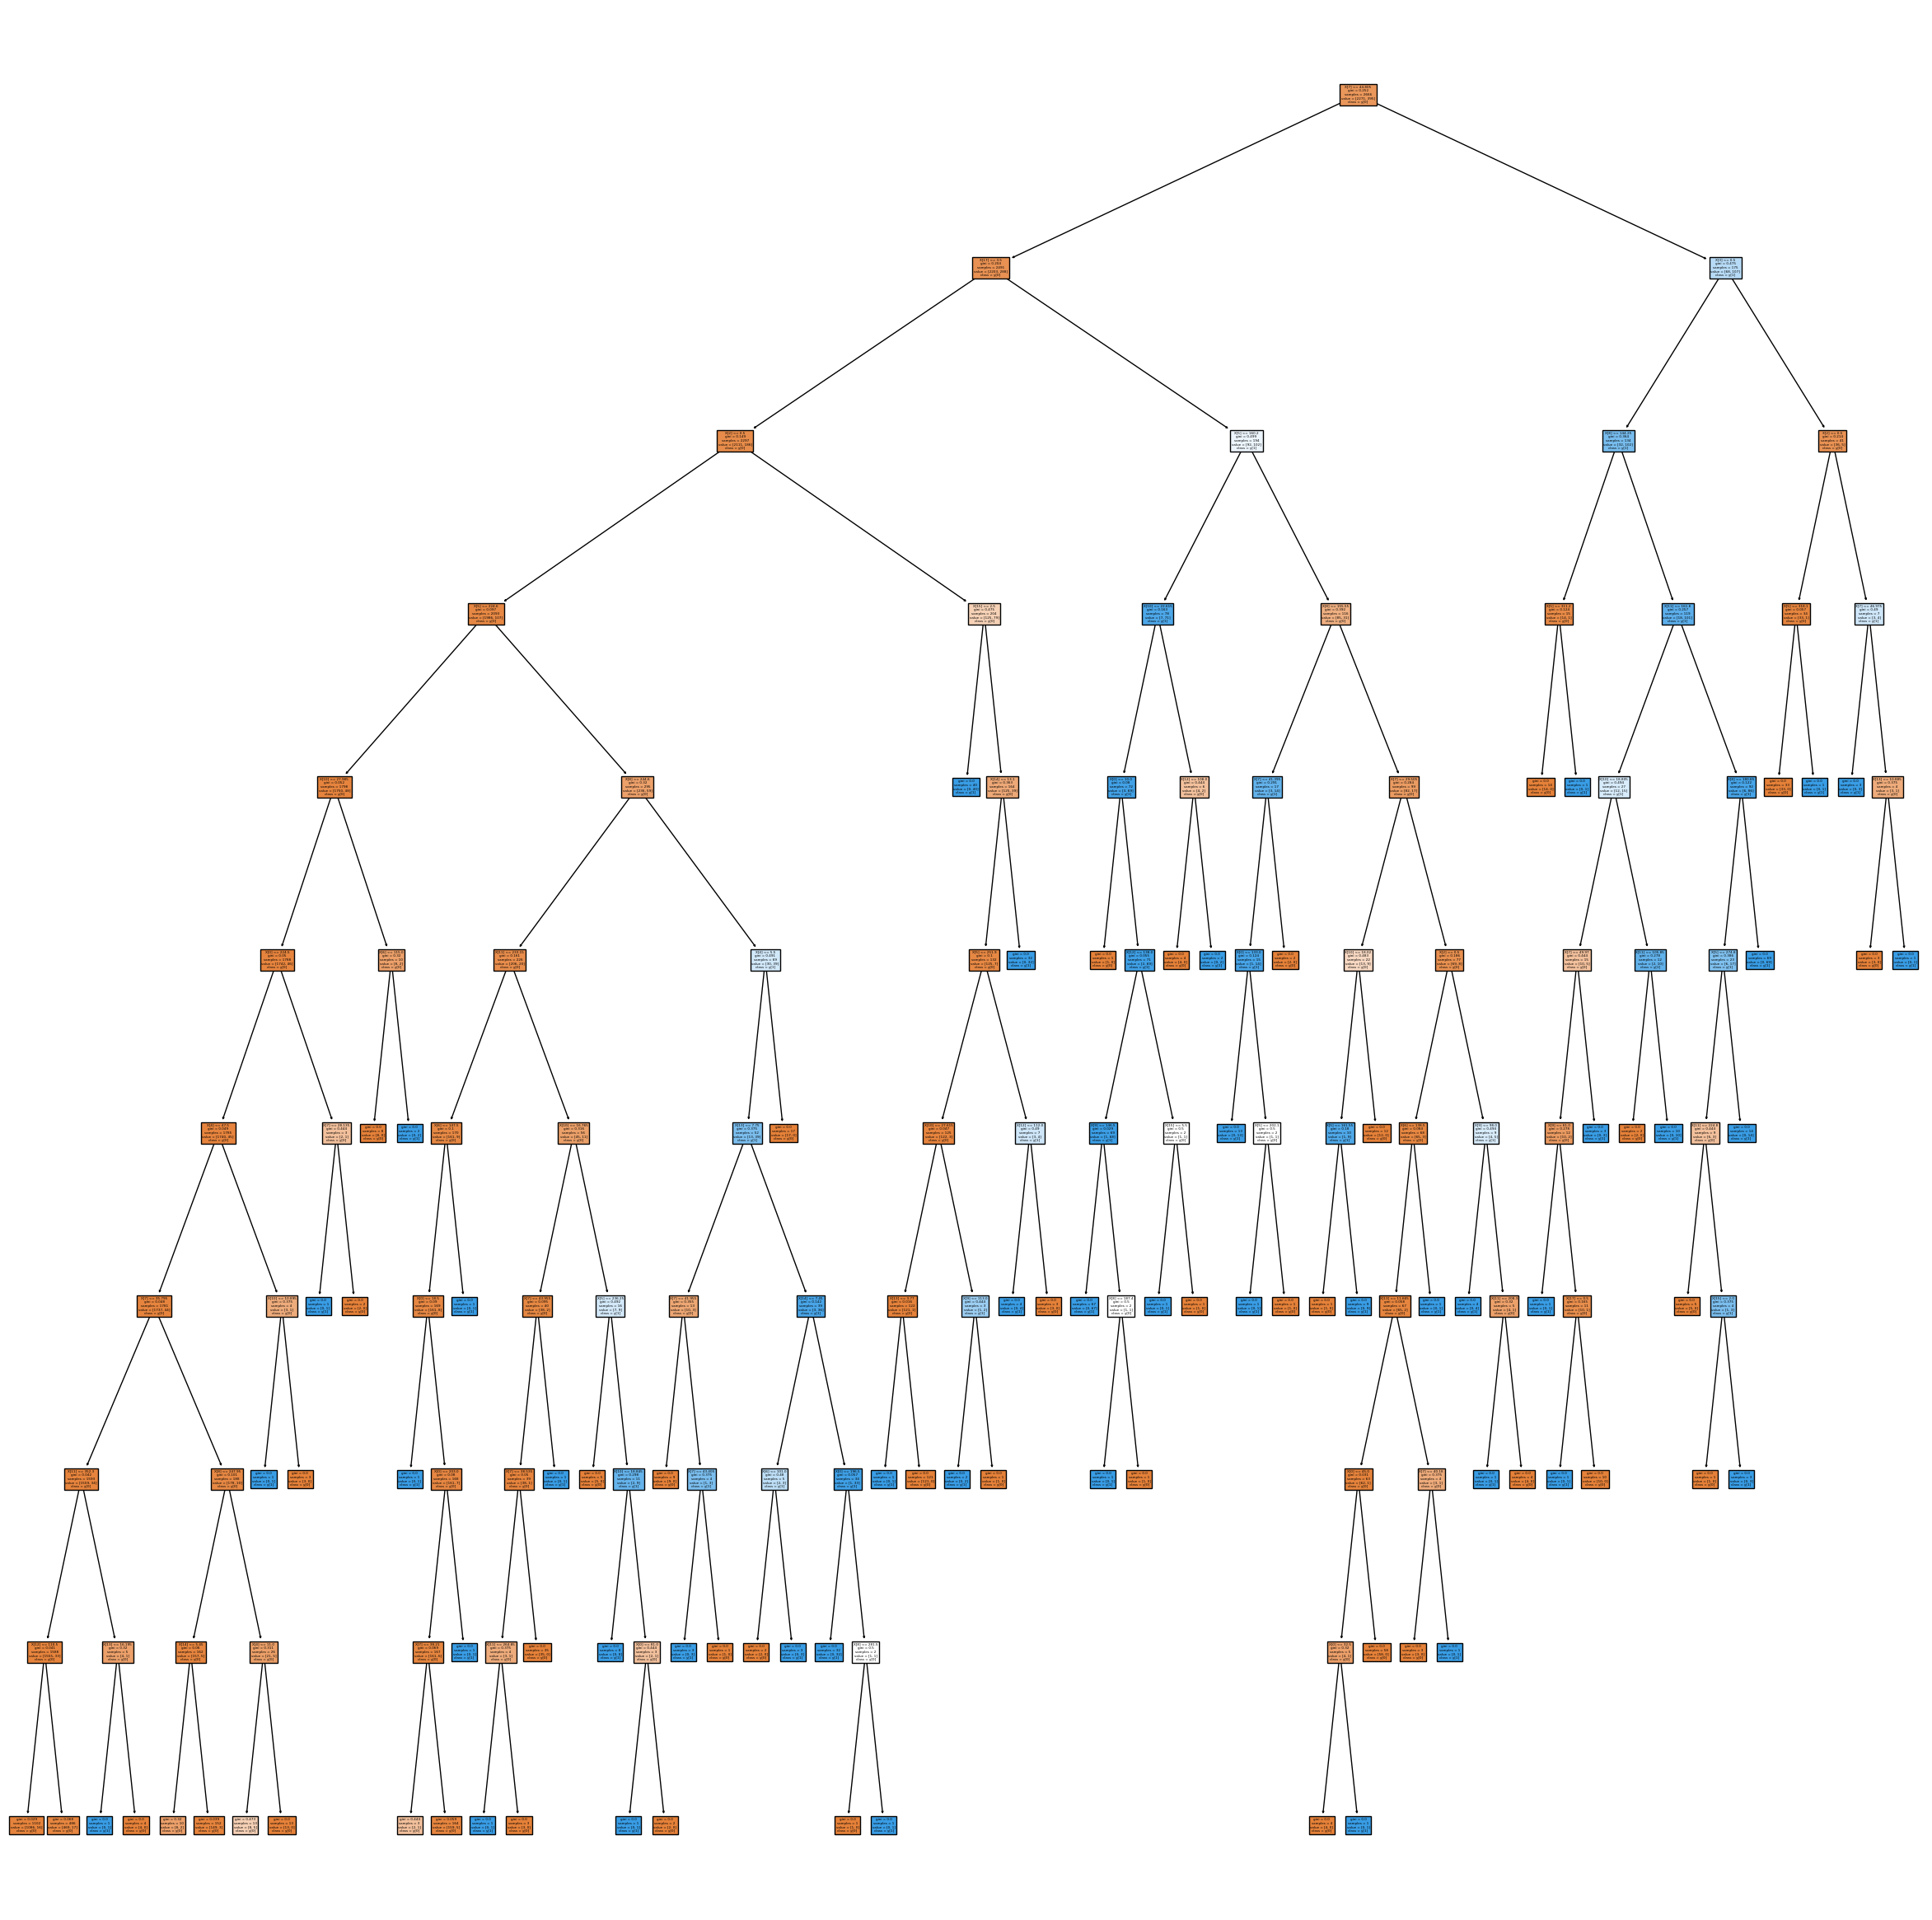

In [62]:
from sklearn import tree as tr
sns.reset_defaults() 
fig = plt.figure(figsize=(30,30))
#plt.figure(figsize=(10, 10))
tr.plot_tree(tree,filled = True,class_names=True)
plt.show()
# You can save your plot if you want
#fig.savefig('imagename2.jpg',dpi=300)



Что делать, если среди всех клиентов, более сколонных уйти от оператора (большая вероятность оттока), мы хотим лучше предсказывать клиентов с большим ожидаемым LTV(или по какому-то другому критерию)?

Тогда нам нужно:
1. настроить регрессионную модель, предсказывающую LTV
2. клиентам с большим ожидаемым LTV присвоить пропрционально больший вес
3. обучать модели классификации, добавив веса объектам обучающей выборки ( используя fit(sample_weight=))

### Метрика AUC ROC:
        
        sklearn.metrics.roc_auc_score(y_true, y_score, *, ...)

In [63]:
from sklearn.metrics import roc_auc_score
y_pred=logreg.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred)
print(roc_auc.round(4))

0.7969


### Оценка качества прогнозов вероятностей: brier_score_loss 
MSE на вероятностях

In [64]:
from sklearn.metrics import brier_score_loss
for clf in [logreg,knn,bagging,forest] :
    y_prob=clf.predict_proba(X_test)
    brier = brier_score_loss(y_test, y_prob[:,1])
    print(type(clf).__name__,':',brier.round(3))


LogisticRegressionCV : 0.098
KNeighborsClassifier : 0.13
BaggingClassifier : 0.051
RandomForestClassifier : 0.068


## Калибровка моделей.


Для оценки степени откалиброванности моделей используют диаграммы надежности (reliability diagramm)
(или график надёжности – Reliability Plot):

<img src="images/reliability_diagramm2.jpg" width="500" height="500" />

  
Посчитаем уверенность(уверенность в классе '1'): средневыборочные вероятности по каждому интервалу вероятностей(mean_conf).

Точность: доля объектов класса '1' в интервале

Интервалы часто выбирают с границами [0, 0.1], [0.1, 0.2] и т.д. 

На рис. 1 розовые столбцы – полученные средние уверенности(усредненные вероятности по бинам), а синие – точности – в соответствующих бинах. 

Чёрным показана доля объектов выборки, попавших в соответствующий бин. 

Чем больше доля, тем надёжнее оценки уверенности и точности. 

В случае, если синий столбец выше розового, говорят о недостаточной уверенности (**under-confident**) модели, если ниже – о чрезмерной уверенности или «пере-уверенности» (**over-confident**).


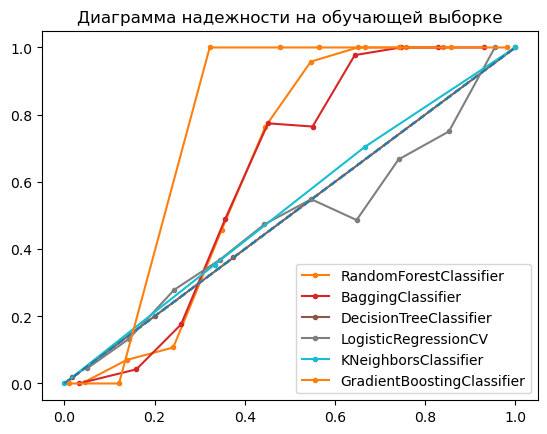

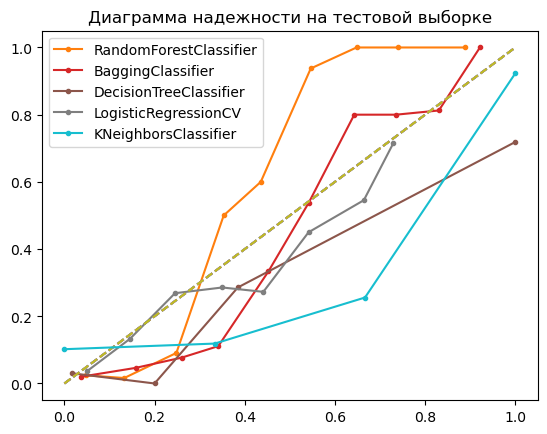

In [109]:
from sklearn.calibration import calibration_curve
# predict probabilities
for clf in [forest,bagging,tree,logreg,knn,boost]:
    probs = clf.predict_proba(X_train)[:,1]
    # reliability diagram
    fop, mpv = calibration_curve(y_train, probs, n_bins=10)
    # plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    plt.plot(mpv, fop, marker='.',label=type(clf).__name__)
    plt.title("Диаграмма надежности на обучающей выборке")
    plt.legend()
plt.show()

for clf in [forest,bagging,tree,logreg,knn]:
    probs = clf.predict_proba(X_test)[:,1]
    # reliability diagram
    fop, mpv = calibration_curve(y_test, probs, n_bins=10)
    # plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    plt.plot(mpv, fop, marker='.',label=type(clf).__name__)
    plt.title("Диаграмма надежности на тестовой выборке")
    plt.legend()
plt.show()

Для калибровки классификатора используем:

class sklearn.calibration.CalibratedClassifierCV(base_estimator=None, *, method='sigmoid', cv=None, n_jobs=None, ensemble=True)
- method{‘sigmoid’, ‘isotonic’}, default=’sigmoid’
- cvint, cross-validation generator, iterable or “prefit”

Откалибруем случайный лес и проверим на тестовой выборке

In [110]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_forest = CalibratedClassifierCV(base_estimator=forest,method='isotonic', cv='prefit')
calibrated_forest.fit(X_train,y_train)
calibrated_tree = CalibratedClassifierCV(base_estimator=tree,method='isotonic', cv='prefit')
calibrated_tree.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(max_depth=10),
                       cv='prefit', method='isotonic')

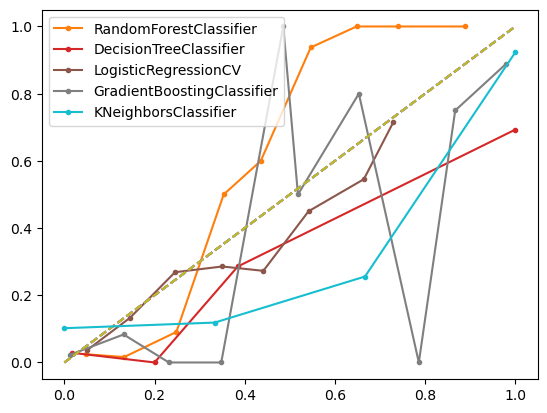

In [77]:
for clf in [forest,tree,logreg,boost,knn]:
    calibrated_model = CalibratedClassifierCV(base_estimator=clf,method='isotonic', cv='prefit')
    calibrated_model.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)[:,1]
    
    # reliability diagram
    fop, mpv = calibration_curve(y_test, probs, n_bins=10)
    # plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    plt.plot(mpv, fop, marker='.',label=type(clf).__name__)
    plt.legend()
    
plt.show()

#### При выборе алгоритма среди примерно похожих по качеству может стать определяющей хорошая калибровка (и ре-калибруемость) модели (если важно как можно точнее предсказать вероятность оттока, отклика, дефолта итп.)

Мониторинг модели: дивергенция Кульбека-Лейбнера на признаках